### 安裝新版的imgaug (因為是在colab)

In [ ]:
!pip uninstall imgaug

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9


In [ ]:
!pip install imgaug==0.4.0

     |████████████████████████████████| 948 kB 24.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:

import shutil
import time


#Imports
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import  DataLoader,Dataset
import torchvision.transforms as tt
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
%matplotlib inline

import imageio
import imgaug as ia
from imgaug import augmenters as iaa

#import pretrainedmodels


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import skimage
from skimage.io import imread



import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# import pytorch_lightning as pl
# from pytorch_lightning import loggers as pl_loggers
# from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.metrics.functional import accuracy



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/Colab Notebooks/

/gdrive/MyDrive/Colab Notebooks


In [ ]:
ROOT_DIR = os.getcwd()
DATA_DIR = ROOT_DIR + '/data'
%ls

 checkpoint.pth.tar
 data/
'Dirty Data Generator.ipynb'
 DL_Classifier_Training-Imgaug-H004AndH005.ipynb
 DL_Classifier_Training-Imgaug.ipynb
 DL_Classifier_Training.ipynb
 Feature_Extractor_Training.ipynb
 Grad-cam.ipynb
 image-classifier-resnet9.pth
 ImgaugG.ipynb
 Imgaug.ipynb
 IntelImageClassification.ipynb
 intel-image-classification-with-pytorch.ipynb
 Intel-image-classifier-resnet50.pth
 model_best.pth.tar
 PyTorchLightning-RayTune-Imgaug-Classifier.ipynb
 submissions/
 Wood_Classification.ipynb
 WoodImageClassificationImgaug.ipynb
 WoodImageClassification.ipynb
'WoodImageClassification - 複製.ipynb'
 Wood.ipynb
 wood_pytorch_model.ipynb


In [ ]:
#Defining respective directories:
split_train_path = DATA_DIR + '/train/'
train_path = DATA_DIR + '/train/train/'
test_path = DATA_DIR + '/test/test/'
pred_path = DATA_DIR + '/pred/'

#classes in dataset:
classes = os.listdir(train_path)
classes

['MaSx', 'PcSx', 'TgSx', 'UpSx', 'ZzSx']

(225, 225, 3)
Original:


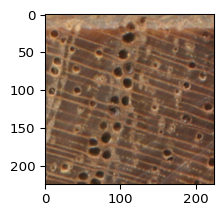

/usr/local/lib/python3.7/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.7/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/segmentation.py:272: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To di

In [ ]:
image = imageio.imread(train_path + "MaSx/Ma1_3.tif")
print(image.shape)
print("Original:")
ia.imshow(image)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.


aug = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=False
)

BATCH_SIZE = 16
NB_BATCHES = 100

images = [np.copy(image) for _ in range(BATCH_SIZE)]
import time
from imgaug.augmentables.batches import UnnormalizedBatch
batches = [UnnormalizedBatch(images=images) for _ in range(NB_BATCHES)]
time_start = time.time()
batches_aug = list(aug.augment_batches(batches, background=True))  # background=True for multicore aug
time_end = time.time()

Augmentation done in 25.19s


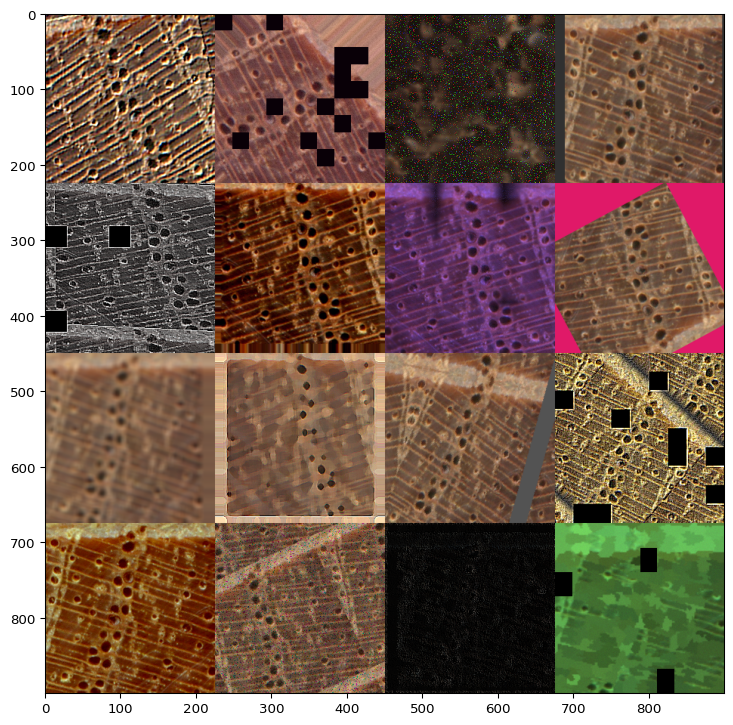

'images_aug = [aug(image=image) for _ in range(20)]\n\nprint("Augmented:")\nia.imshow(ia.draw_grid(images_aug, cols=5, rows=4))'

In [ ]:
print("Augmentation done in %.2fs" % (time_end - time_start,))
ia.imshow(ia.draw_grid([batches_aug[0].images_aug[i] for i in range(16)]))


"""images_aug = [aug(image=image) for _ in range(20)]

print("Augmented:")
ia.imshow(ia.draw_grid(images_aug, cols=5, rows=4))"""

Original:


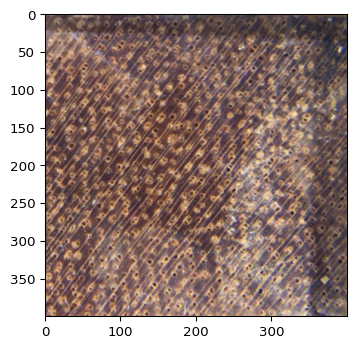

(400, 400, 3)
Augmented:


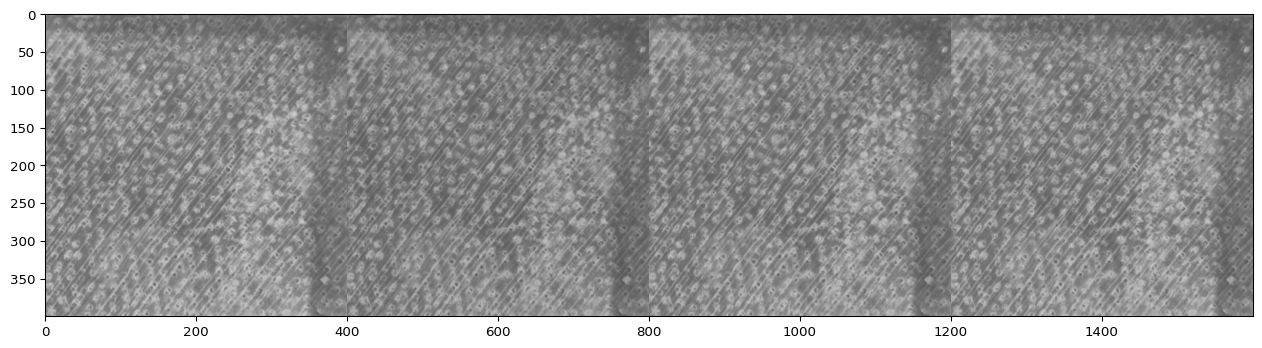

In [ ]:
image = imageio.imread(test_path + "MaSx/Ma1_2.tif")
image = skimage.img_as_ubyte(skimage.transform.resize(image, (400, 400)))
print("Original:")
ia.imshow(image)

seq = iaa.Sequential([    
    iaa.SomeOf((4, 8), [
        iaa.Multiply((0.9, 1.2)),
        iaa.OneOf([
            iaa.Sometimes(0.3, iaa.UniformColorQuantization(n_colors=(16, 256)))
        ]),
        iaa.OneOf([
                iaa.Affine(
                    scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, # scale images to 90-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-10, 10), # shear by -10 to +10 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ),
            ]),
        #iaa.CropAndPad(px=((0, 50)), pad_mode=ia.ALL, pad_cval=(0, 128)),
        iaa.LinearContrast((0.5, 1.5)),
        iaa.Sometimes(0.3, iaa.Sharpen(alpha=(0, 1.0), lightness=(1.0, 1.5))),
        #iaa.Sometimes(0.3, iaa.pillike.Autocontrast()),
        iaa.Sometimes(0.1, iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.2))),
        #iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.05*255)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1.5))),
        #iaa.Sometimes(0.3, iaa.MotionBlur(k=(3, 7), angle=[0, 90])),
], random_order=False)
], random_order=False)

images_aug = [seq(image=image) for _ in range(4)]

print(images_aug[0].shape)

print("Augmented:")
ia.imshow(ia.draw_grid(images_aug, cols=4, rows=1))